In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch.distributions.mixture_same_family import MixtureSameFamily
import torch.distributions as DIST
import pandas as pd
import seaborn as sns


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def identity_init(layers):
    for layer in layers:
        nn.init.eye_(layer.weight)
        nn.init.zeros_(layer.bias)

class LinearVAUB(nn.Module):
    def __init__(self, input_features=1, latent_features=1, hidden_features=3, option="CF", learnable_loc=False, learnable_var=False, pz=None, p_noise=False):
        super(LinearVAUB, self).__init__()

        # encoder & decoder
        # self.enc1 = nn.Sequential(
        #     nn.Linear(in_features=input_features, out_features=hidden_features),
        #     nn.ReLU(),
        #     nn.Linear(in_features=hidden_features, out_features=latent_features*2),
        # )
        #
        # self.enc2 = nn.Sequential(
        #     nn.Linear(in_features=input_features, out_features=hidden_features),
        #     nn.ReLU(),
        #     nn.Linear(in_features=hidden_features, out_features=latent_features*2),
        # )

        self.enc1 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=latent_features*2)
        )

        self.enc2 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=latent_features*2)
        )
        identity_init(self.enc1)
        identity_init(self.enc2)

        self.dec1 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=input_features),
        )

        self.dec2 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=input_features),
        )

        self.E_arr = [self.enc1, self.enc2]
        self.D_arr = [self.dec1, self.dec2]

        # shared distribution
        '''
        change this line
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        to
        '''
        if p_noise is None:
            self.inject_noise = False
        else:
            self.inject_noise = True
            self.p_noise = p_noise

        self.log_scale_arr = [nn.Parameter(torch.Tensor([0.0])) for _ in range(2)]

        self.latent_loc = nn.Parameter(torch.Tensor([0.0])) if learnable_loc else torch.Tensor([0.0])
        self.latent_log_var = nn.Parameter(torch.Tensor([0.0])) if learnable_var else torch.Tensor([0.0])

        self.Recon_Loss = [[],[]]

        self.mu = None
        self.log_var = None
        self.elbo = None
        self.criterion = nn.MSELoss()

        self.option = option
        if pz:
            self.pz = pz
            self.option = "MC-PZ"


    def reparameterize(self, mu, log_var):

        std = torch.exp(log_var/2).float()
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return z

    def forward(self, x_input, scale_recon=1):

        self.recon_loss = 0
        self.elbo = 0
        self.z_arr = []
        self.x_hat_arr = []

        for idx in range(2):
            x_original = x_input[idx]
            x = x_input[idx]
            # encoding
            x = self.E_arr[idx](x)

            # get `mu` and `log_var`
            self.mu = x[:, 0, None] # the first feature values as mean
            self.log_var = x[:, 1, None] # the other feature values as variance

            # get the latent vector through reparameterization
            z = self.reparameterize(self.mu, self.log_var)
            self.z_arr.append(z)

            # decoding
            x_hat = self.D_arr[idx](z)
            self.x_hat_arr.append(x_hat)

            if self.option == "MC":
                # reconstruction loss
                recon_loss = -1*self.gaussian_likelihood(x_hat, x_original, self.log_scale_arr[idx])
                self.Recon_Loss[idx].append(recon_loss.mean().item())

                # kl loss
                kl_loss = self.kl_divergence(z, self.mu, self.log_var)

                # elbo
                elbo = kl_loss + scale_recon*recon_loss

            if self.option == "MC-PZ":
                # reconstruction loss
                recon_loss = -1*self.gaussian_likelihood(x_hat, x_original, self.log_scale_arr[idx])
                self.Recon_Loss[idx].append(recon_loss.mean().item())

                # kl loss
                if self.inject_noise:
                    z_noisy = z + self.p_noise.sample(z.size())
                    # print(z.size(), z_noisy.size())
                    kl_loss = self.kl_divergence_with_pz(z, self.mu, self.log_var, z_noisy=z_noisy)
                else:
                    kl_loss = self.kl_divergence_with_pz(z, self.mu, self.log_var)

                # elbo
                elbo = kl_loss + scale_recon*recon_loss

            self.recon_loss += recon_loss.mean()
            self.elbo += elbo.mean()

        return x_hat

    def kl_divergence_with_pz(self, z, mu, log_var, z_noisy=None):

        # mu = self.mu
        std = torch.exp(log_var/2)

        # p = torch.distributions.Normal(torch.zeros_like(mu)+self.latent_loc, torch.ones_like(std)*torch.exp(self.latent_log_var/2))
        # p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        # log_pz = p.log_prob(z)
        if z_noisy is None:
            log_pz = self.pz.log_prob(z)
        else:
            log_pz = self.pz.log_prob(z_noisy)

        kl = (log_qzx - log_pz)

        # sum over last dim to go from single dim distribution to multi-dim
        kl = kl.sum(-1)
        return kl


    def kl_divergence(self, z, mu, log_var):

        # mu = self.mu
        std = torch.exp(log_var/2)

        p = torch.distributions.Normal(torch.zeros_like(mu)+self.latent_loc, torch.ones_like(std)*torch.exp(self.latent_log_var/2))
        # p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)

        # sum over last dim to go from single dim distribution to multi-dim
        kl = kl.sum(-1)
        return kl


    def gaussian_likelihood(self, x_hat, x, learnable_scale):
        scale = torch.exp(learnable_scale)
        mean = x_hat
        # print(mean.size(), scale.size())
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        # print(mean.size(), x.size())
        log_pxz = dist.log_prob(x)
        # print(log_pxz.size(), log_pxz.sum(-1).size())
        return log_pxz.sum(-1)


def get_1D_data(mu_arr, std_arr, n_sample):

    mu1, var1 = torch.tensor([mu_arr[0]], dtype=float), torch.tensor([[std_arr[0]]], dtype=float)
    mu2, var2 = torch.tensor([mu_arr[1]], dtype=float), torch.tensor([[std_arr[1]]], dtype=float)

    x1 = MultivariateNormal(loc=mu1, scale_tril=var1).sample(torch.tensor([n_sample]))
    x2 = MultivariateNormal(loc=mu2, scale_tril=var2).sample(torch.tensor([n_sample]))

    return [x1.float(), x2.float()]


def plot_normal_dist(data, ax, xmin, xmax, color, name):
    data = np.array(data)

    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)

    # Plot the histogram.
#     ax.hist(data, bins=num_bins, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    x = np.linspace(xmin, xmax, 1000)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, color, linewidth=2, label=name)
    # ax.legend()


def train_VAUB(model, X_arr, n_epochs, lr, scale_recon):

    opt = torch.optim.Adam(params=model.parameters(), lr=lr)

    Loss = []
    # Loss_KL = []
    Loss_recon = []

    for epoch in range(n_epochs):

        model.train()
        opt.zero_grad()

        x_hat = model(X_arr, scale_recon=scale_recon)
        loss = model.elbo
        loss.backward()
        opt.step()

        Loss.append(loss.item())
        Loss_recon.append(model.recon_loss.item())

    return Loss_recon, Loss, model

class MoGNN(nn.Module):

    def __init__(self, n_components, input_dim, loc_init=None, scale_init=None, weight_init=None):

        super(MoGNN, self).__init__()

        if loc_init is None:
            self.loc = nn.Parameter((torch.rand(n_components, input_dim)*20-1))
        else:
            self.loc = nn.Parameter(loc_init)

        if scale_init is None:
            self.log_scale = nn.Parameter(torch.zeros(n_components, input_dim))
        else:
            self.log_scale = nn.Parameter(torch.log(scale_init))

        if weight_init is None:
            self.raw_weight = nn.Parameter(torch.ones(n_components))
        else:
            self.raw_weight = nn.Parameter(torch.log(weight_init/(1-weight_init)))

    def log_prob(self, Z):

        self.loc = self.loc.to(Z.device)
        self.log_scale = self.log_scale.to(Z.device)
        self.raw_weight = self.raw_weight.to(Z.device)

        # print(torch.sigmoid(self.raw_weight))
        mix = torch.distributions.Categorical(torch.sigmoid(self.raw_weight))
        comp = torch.distributions.Independent(torch.distributions.Normal(self.loc, torch.exp(self.log_scale)), 1)
        gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

        return gmm.log_prob(Z)


def plot_loss(Loss, model, xmin, xmax):
    x_arr = model.x_hat_arr
    z_arr = model.z_arr
    D_arr = model.D_arr
    Recon_Loss = model.Recon_Loss

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(Recon_Loss[0], label="recon_loss_0")
    ax.plot(Recon_Loss[1], label="recon_loss_1")
    ax.set_title("Reconstruction Loss")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 8))
    plot_normal_dist(x_arr[0].detach(), ax, xmin, xmax, 'b', 'x1-reconstructed')
    plot_normal_dist(x_arr[1].detach(), ax, xmin, xmax, 'k', 'x2-reconstructed')
    plot_normal_dist(z_arr[0].detach(), ax, xmin, xmax, 'r', 'z1')
    plot_normal_dist(z_arr[1].detach(), ax, xmin, xmax, 'm', 'z2')
    plt.legend()

    X_hat_rev_arr = []
    for D, z in zip(D_arr, z_arr[::-1]):
        X_hat_rev_arr.append(D(z))

    fig, ax = plt.subplots(figsize=(15, 8))
    plot_normal_dist(X_hat_rev_arr[0].detach(), ax, xmin, xmax, 'b', 'fake x2')
    plot_normal_dist(X_hat_rev_arr[1].detach(), ax, xmin, xmax, 'k', 'fake x1')
    plt.legend()


def plot_loss_gmm(Loss_rec, Loss, model, xmin, xmax, kwarg_list):
    x_hat_arr = model.x_hat_arr
    z_arr = model.z_arr
    D_arr = model.D_arr
    Recon_Loss = model.Recon_Loss
    kwargs_x0, kwargs_x1 = kwarg_list

    # Plot reconstruction loss
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(Recon_Loss[0], label="recon_loss_0")
    ax.plot(Recon_Loss[1], label="recon_loss_1")
    ax.set_title("Reconstruction Loss")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(Loss, label="Loss")
    ax.set_title("Overall Loss")
    plt.legend()
    plt.show()

    # Plot X, Z, X_reconstructed
    x_sample = torch.linspace(xmin, xmax, 500)
    plt.figure()
    plt.plot(x_sample, gmm(**kwargs_x0).log_prob(x_sample).exp(), '--r', label="x0")
    plt.plot(x_sample, gmm(**kwargs_x1).log_prob(x_sample).exp(), '--b', label="x1")
    plt.scatter(z_arr[0].detach(), [0]*len(z_arr[0].detach()), c='c', marker='+', label='z0')
    plt.scatter(z_arr[1].detach(), [0.1]*len(z_arr[1].detach()), c='m', marker='+', label='z1')
    plt.scatter(x_hat_arr[0].detach(), [0.2]*len(x_hat_arr[0].detach()), c='r', marker='+', label='x0-reconstruct')
    plt.scatter(x_hat_arr[1].detach(), [0.3]*len(x_hat_arr[1].detach()), c='b', marker='+', label='x1-reconstruct')
    plt.legend()
    plt.show()

    X_hat_rev_arr = []
    for D, z in zip(D_arr, z_arr[::-1]):
        X_hat_rev_arr.append(D(z))

    x_sample = torch.linspace(xmin, xmax, 500)
    plt.figure()
    plt.plot(x_sample, gmm(**kwargs_x0).log_prob(x_sample).exp(), '--r', label="x0")
    plt.plot(x_sample, gmm(**kwargs_x1).log_prob(x_sample).exp(), '--b', label="x1")
    plt.scatter(X_hat_rev_arr[0].detach(), [0]*len(X_hat_rev_arr[0].detach()), c='r', marker='+', label='fake x1')
    plt.scatter(X_hat_rev_arr[1].detach(), [0.2]*len(X_hat_rev_arr[1].detach()), c='b', marker='+', label='fake x0')
    plt.legend()
    plt.show()



def gmm(weight, loc, scale):
    mix = DIST.Categorical(weight)
    comp = DIST.Normal(loc, scale)
    return MixtureSameFamily(mix, comp)


def get_gmm_data(kwargs_x0, kwargs_x1, n_sample, plot=False, x_min=None, x_max=None):

    x1 = gmm(**kwargs_x0).sample(torch.tensor([n_sample])).unsqueeze(1)
    x2 = gmm(**kwargs_x1).sample(torch.tensor([n_sample])).unsqueeze(1)

    if plot:
        x_sample = torch.linspace(x_min, x_max, 500)
        plt.figure()
        plt.plot(x_sample, gmm(**kwargs_x0).log_prob(x_sample).exp(), 'r', label="x0")
        plt.plot(x_sample, gmm(**kwargs_x1).log_prob(x_sample).exp(), 'b', label="x1")
        plt.legend()
        plt.show()

    return [x1.float(), x2.float()]

In [8]:
############################################
#####     Training hyperparameters     #####
############################################
n_epochs = 2500
lr = 5e-3
input_features = 1
hidden_features = 10
latent_features = 1
N = int(1e3)
scale_recon = 1
xmin, xmax = -30, 30
noise_scale = 10
vae_option = "MC-PZ"

kwargs_pz = {
    "n_components": 2,
    "input_dim": 1,
    "loc_init": torch.tensor([[-20.], [20.]]),
    }

kwargs_train = {
    "n_epochs": n_epochs,
    "lr": lr,
    "scale_recon": scale_recon,
}

kwargs_x0 = {
    "weight": torch.ones(1,),
    "loc": torch.zeros(1,)-20,
    "scale": torch.ones(1,),
}

kwargs_x1 = {
    "weight": torch.ones(1,),
    "loc": torch.zeros(1,)+20,
    "scale": torch.ones(1,),
}

p_noise = torch.distributions.Normal(0, noise_scale)
############################################
#####         Training models          #####
############################################
pz = MoGNN(**kwargs_pz)

vaub_w = LinearVAUB(
    input_features=input_features,
    hidden_features=hidden_features,
    latent_features=latent_features,
    option = vae_option,
    pz = pz,
    p_noise = p_noise
)

############################################
#####          Training data           #####
############################################
X_arr = get_gmm_data(kwargs_x0, kwargs_x1, N, plot=False, x_min=xmin, x_max=xmax)

############################################
#####        Training script           #####
############################################
Loss_rec_w, Loss_w, vaub = train_VAUB(vaub_w, X_arr, **kwargs_train)

############################################
#####       Visulizing script          #####
############################################
# plot_loss_gmm(Loss_rec_w, Loss_w, vaub, xmin, xmax, [kwargs_x0, kwargs_x1])

In [16]:
############################################
#####     Training hyperparameters     #####
############################################
n_epochs = 1250
lr = 5e-3
input_features = 1
hidden_features = 10
latent_features = 1
N = int(1e3)
scale_recon = 1
xmin, xmax = -30, 30
noise_scale = 1e-8
vae_option = "MC-PZ"

kwargs_pz = {
    "n_components": 2,
    "input_dim": 1,
    "loc_init": torch.tensor([[-20.], [20.]]),
    }

kwargs_train = {
    "n_epochs": n_epochs,
    "lr": lr,
    "scale_recon": scale_recon,
}

kwargs_x0 = {
    "weight": torch.ones(1,),
    "loc": torch.zeros(1,)-20,
    "scale": torch.ones(1,),
}

kwargs_x1 = {
    "weight": torch.ones(1,),
    "loc": torch.zeros(1,)+20,
    "scale": torch.ones(1,),
}

p_noise = torch.distributions.Normal(0,


                                     )
############################################
#####         Training models          #####
############################################
pz = MoGNN(**kwargs_pz)

vaub_wo = LinearVAUB(
    input_features=input_features,
    hidden_features=hidden_features,
    latent_features=latent_features,
    option = vae_option,
    pz = pz,
    p_noise = p_noise
)

############################################
#####          Training data           #####
############################################
X_arr = get_gmm_data(kwargs_x0, kwargs_x1, N, plot=False, x_min=xmin, x_max=xmax)

############################################
#####        Training script           #####
############################################
Loss_rec_wo, Loss_wo, vaub = train_VAUB(vaub_wo, X_arr, **kwargs_train)

############################################
#####       Visulizing script          #####
############################################
# plot_loss_gmm(Loss_rec_wo, Loss_wo, vaub, xmin, xmax, [kwargs_x0, kwargs_x1])

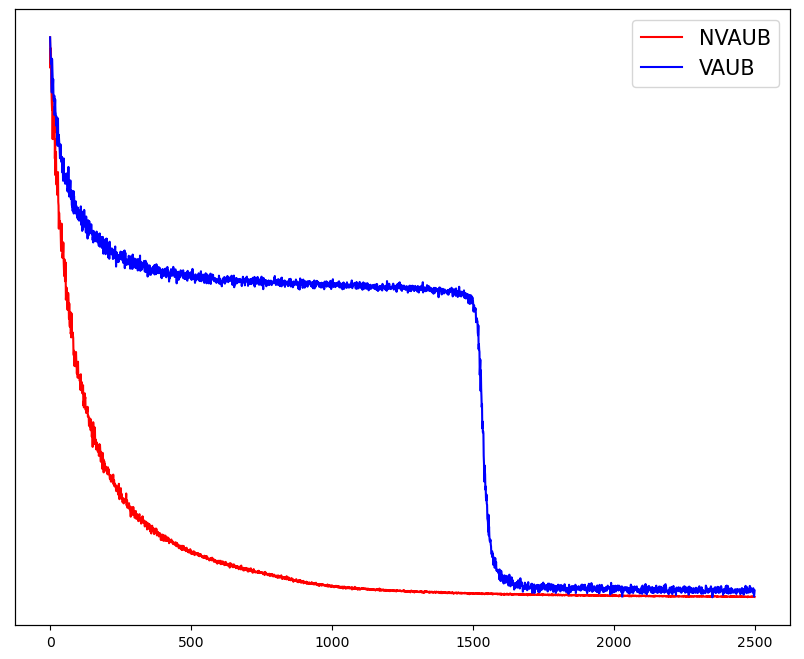

457.10015869140625 39.748512268066406


In [15]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(10, 8))
ax_2 = ax.twinx()
lns1 = ax.plot(Loss_w, label="NVAUB", c='red')
lns2 = ax_2.plot(Loss_wo, label="VAUB", c='blue')
# ax.set_title("Overall Loss")
ax.yaxis.set_visible(False)
ax_2.yaxis.set_visible(False)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=15)
plt.show()

print(Loss_w[-1], Loss_wo[-1])

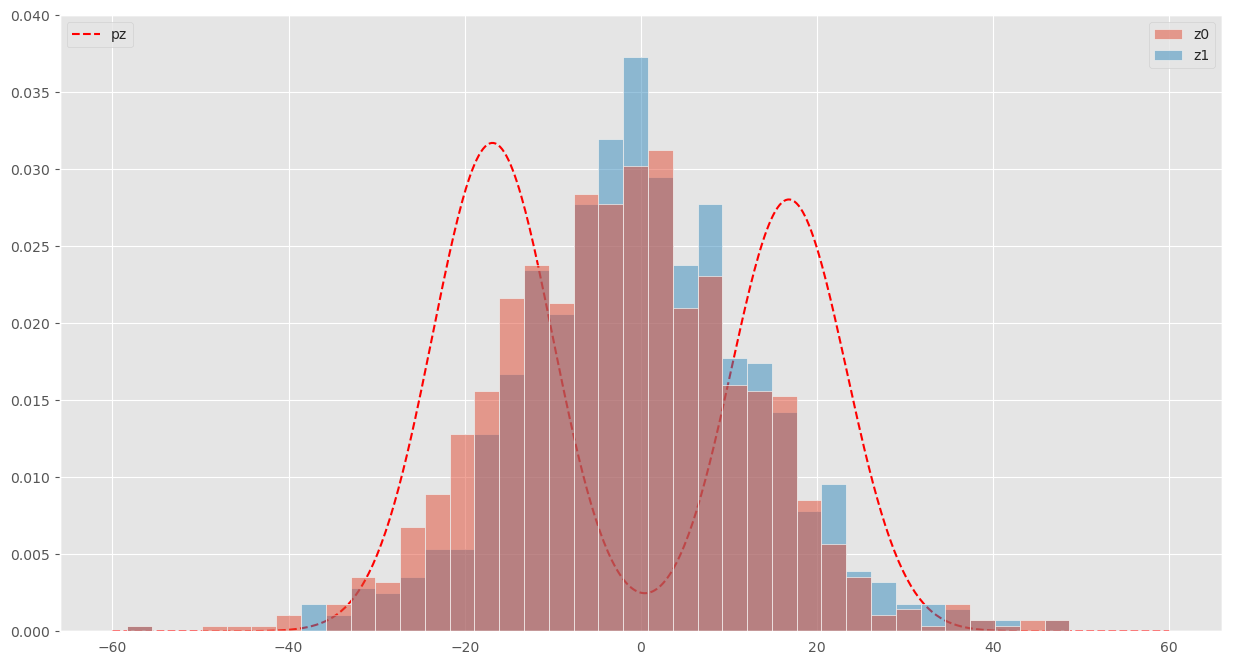

In [7]:
x_sample = torch.linspace(-60, 60, 500)
fig, ax = plt.subplots(figsize=(15, 8))
ax_2 = ax.twinx()
ax.set_ylim([0, 0.04])
ax_2.set_ylim([0, 0.02])
ax_2.get_yaxis().set_visible(False)
# print(model.pz.log_prob(x_sample.unsqueeze(1)).exp().size())

ax.plot(x_sample, vaub_w.pz.log_prob(x_sample.unsqueeze(1)).exp().detach().numpy(), '--r', label="pz")
ax.legend(loc="upper left")

dataset = pd.DataFrame({
    "z0": vaub_w.z_arr[0].detach().numpy().ravel(),
    "z1": vaub_w.z_arr[1].detach().numpy().ravel(),
    # "x0_recon": x_hat_arr[0].detach().numpy().ravel(),
    # "x1_recon": x_hat_arr[1].detach().numpy().ravel(),
}, np.arange(len(vaub_w.z_arr[0])))
sns.histplot(data=dataset, stat='density', kde=False, ax=ax_2, legend=True)

plt.show()

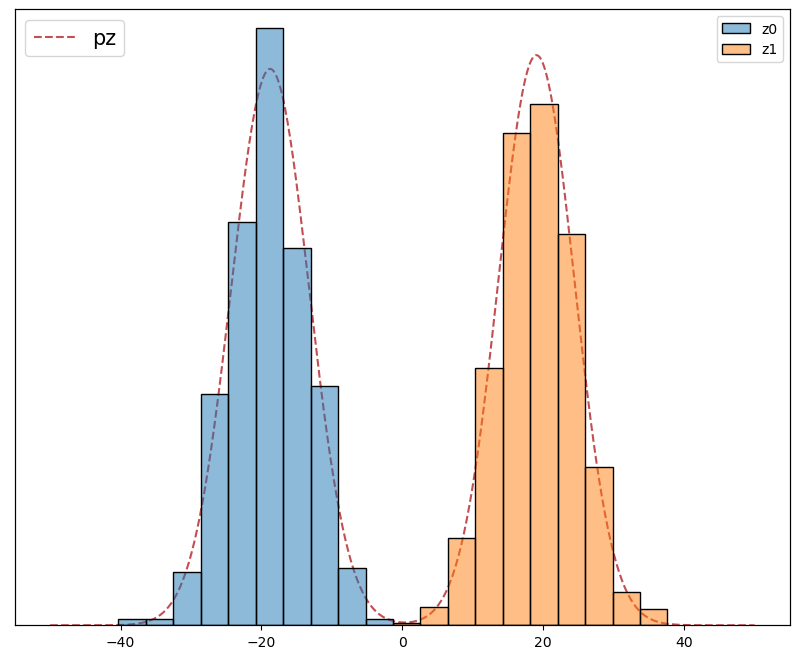

In [26]:
x_sample = torch.linspace(-50, 50, 500)
fig, ax = plt.subplots(figsize=(10, 8))
ax_2 = ax.twinx()
ax.set_ylim([0, 0.04])
ax_2.set_ylim([0, 0.04])
ax.get_yaxis().set_visible(False)
ax_2.get_yaxis().set_visible(False)
# print(model.pz.log_prob(x_sample.unsqueeze(1)).exp().size())
plt.style.use('default')
ax.plot(x_sample, vaub_wo.pz.log_prob(x_sample.unsqueeze(1)).exp().detach().numpy(), '--r', label="pz")
ax.legend(loc="upper left", fontsize=15)

sns.set(font_scale=2)
dataset = pd.DataFrame({
    "z0": vaub_wo.z_arr[0].detach().numpy().ravel(),
    "z1": vaub_wo.z_arr[1].detach().numpy().ravel(),
    # "x0_recon": x_hat_arr[0].detach().numpy().ravel(),
    # "x1_recon": x_hat_arr[1].detach().numpy().ravel(),
}, np.arange(len(vaub_wo.z_arr[0])))
plt.style.use('default')

sns.histplot(data=dataset, stat='density', kde=False, ax=ax_2, legend=True, bins=20)

plt.show()